# Covid Restrictions.

**Setting up the environment**
Initialization of the Ontology editor in Jupyter Notebook

In [1]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np
import pandas as pd
import pickle
import datetime

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    


Lets setup the fist ontology editor for the general knowledge. The editor allows you to enter the knowledge in text format, and support you with the prdictive editor.

In [2]:
policies=pd.read_csv('https://raw.githubusercontent.com/saudiwin/corona_tscs/master/data/CoronaNet/data_country/coronanet_release/coronanet_release_Australia.csv', encoding='cp1252',index_col=0)

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

c:\users\pkapl\anaconda3\envs\makler\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [36]:
policies_cnl_lines=[]
for i,row in policies[policies['entry_type']=='new_entry'].iterrows():
    policies_cnl_lines.append(f"Australia introduced Policy-{row.policy_id}.")
    policies_cnl_lines.append(f"Policy-{row.policy_id} is a restriction and was-introduced equal-to {row.date_start}.")
    if not row.date_end!=row.date_end:
        policies_cnl_lines.append(f"Policy-{row.policy_id} was-withdrawn  equal-to {row.date_end}.")    

In [37]:
policies_cnl_lines

['Australia introduced Policy-3144269.',
 'Policy-3144269 is a restriction and was-introduced equal-to 2020-03-24.',
 'Policy-3144269 was-withdrawn  equal-to 2020-04-26.',
 'Australia introduced Policy-3144269.',
 'Policy-3144269 is a restriction and was-introduced equal-to 2020-03-24.',
 'Policy-3144269 was-withdrawn  equal-to 2020-04-26.',
 'Australia introduced Policy-3144269.',
 'Policy-3144269 is a restriction and was-introduced equal-to 2020-03-24.',
 'Policy-3144269 was-withdrawn  equal-to 2020-04-26.',
 'Australia introduced Policy-7778287.',
 'Policy-7778287 is a restriction and was-introduced equal-to 2020-03-24.',
 'Australia introduced Policy-7778287.',
 'Policy-7778287 is a restriction and was-introduced equal-to 2020-03-24.',
 'Australia introduced Policy-4610550.',
 'Policy-4610550 is a restriction and was-introduced equal-to 2020-04-06.',
 'Policy-4610550 was-withdrawn  equal-to 2020-07-12.',
 'Australia introduced Policy-4531517.',
 'Policy-4531517 is a restriction and

In [5]:
parts_editors={}
parts_editors['01']=CnlEditBox('countries.encnl')
parts_editors['02']=CnlEditBox('border_cross_quarantine.encnl')
parts_editors['03']=CnlEditBox('face_cover.encnl')
parts_editors['04']=CnlEditBox('lockdown.encnl')
parts_editors['05']=CnlEditBox('mass_coronavirus_testing.encnl')

<IPython.core.display.Javascript object>

In [6]:
parts_editors['01']

In [7]:
parts_editors['02']

In [8]:
parts_editors['03']

In [9]:
parts_editors['04']

In [10]:
parts_editors['05']

Lets define the function that will build the ontology based on the dict of ontology editors and the optional additional editor for testing purposes. All it is doing it is concatenaiting the values of all the editors and puts them into the newly created ontology object.

In [11]:
def buildOntology(parts_editors,test_editor=None):
    return Ontology("cnl/string",
                    "\n\n".join(k.getvalue() for k in parts_editors.values())+('' if test_editor is None else test_editor.getvalue()) + '\n'.join(policies_cnl_lines), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

onto=buildOntology(parts_editors)

Lets draw our ontology.

In [ ]:
onto.draw_graph(layout='force directed')

You can select and print out all instaces of given concept's name.

In [12]:
regions=onto.select_instances_of("region")
regions

,Instance,introduceds
0,Victoria,"[Mass-Coronavirus-Testing-Victoria, Lockdown-Victoria, Face-Cover-Victoria, Border-Cross-Quarantine-Victoria]"
1,Berlin,"[Mass-Coronavirus-Testing-Berlin, Lockdown-Berlin, Face-Cover-Berlin, Border-Cross-Quarantine-Berlin]"
2,United-Kingdom,None
3,Australia,"[Policy-599939, Policy-4595838, Policy-8888423, Policy-6796297, Policy-4657525, Policy-7451990, Policy-4767813, Policy-9700836, Policy-9564981, Policy-1510199, Policy-2399366, Policy-6421666, Policy-4668893, Face-Cover-Australia, Policy-5963324, Policy-2687817, Policy-6666171, Policy-2813266, Policy-9470914, Policy-4577640, Policy-673496, Policy-5595976, Policy-1658680, Policy-1575088, Policy-357126, Policy-8034041, Policy-5592385, Policy-9527194, Policy-9516857, Policy-9123887, Policy-2528584, Policy-79497, Policy-6092567, Policy-110101, Policy-3973774, Policy-3968553, Policy-9994627, Policy-6537372, Policy-8245407, Policy-5268047, Policy-9482658, Policy-5442485, Policy-4531517, Policy-7234085, Policy-6543237, Policy-5755613, Policy-6285196, Policy-9716056, Policy-30924, Policy-5695934, Policy-4639193, Policy-5081649, Policy-5763252, Policy-4518550, Policy-1401063, Policy-8847595, Policy-2751659, Policy-536454, Policy-3157527, Policy-3411907, Policy-9631567, Policy-4262917, Policy-1026838, Policy-9458966, Policy-9372846, Policy-3356576, Policy-7032136, Policy-6602530, Policy-1724992, Policy-3225476, Policy-2568387, Policy-2577721, Policy-2586418, Policy-1413216, Policy-7396432, Policy-6174681, Policy-4542908, Policy-3058219, Policy-3126988, Policy-3028558, Policy-7609003, Policy-7549220, Policy-447804, Policy-6405214, Policy-8433226, Policy-9738776, Policy-5055528, Policy-8504979, Policy-7079987, Policy-9719145, Policy-4060611, Policy-9401044, Policy-7700961, Policy-9219740, Policy-1705305, Policy-257258, Policy-1222789, Policy-559206, Policy-7300492, Policy-6532586, ...]"
4,Bavaria,"[Mass-Coronavirus-Testing-Bavaria, Lockdown-Bavaria, Face-Cover-Bavaria, Border-Cross-Quarantine-Bavaria]"
5,New-York,"[Lockdown-New-York, Face-Cover-New-York, Border-Cross-Quarantine-New-York]"
6,California,"[Lockdown-California, Face-Cover-California]"
7,Sweden,Border-Cross-Quarantine-Sweden
8,Poland,"[Lockdown-Poland, Face-Cover-Poland, Border-Cross-Quarantine-Poland]"
9,Germany,None


Cognipy allows you to do queries on ontology using sparql language. In example we query for every region which has indtroduced some restriction and then we save it to pandas dataframe. 

In [13]:
df=onto.sparql_query(CQL("""select ?region ?restriction ?date{
                            ?region rdf:type <region>. 
                            ?restriction rdf:type <restriction>. 
                            ?region <introduceds> ?restriction. 
                            ?restriction <was-introduced> ?date.
                        }"""))

In [14]:
df['date'] = pd.to_datetime(pd.to_datetime(df['date']).apply(lambda x: x.strftime('%d/%m/%Y')))
df.set_index('date',inplace=True)

In [15]:
df

,region,restriction
date,,
2020-06-08,Victoria,Lockdown-Victoria
2020-02-08,Victoria,Face-Cover-Victoria
2020-03-15,Victoria,Border-Cross-Quarantine-Victoria
2020-03-23,Berlin,Lockdown-Berlin
2020-04-21,Berlin,Face-Cover-Berlin
2020-04-22,Berlin,Border-Cross-Quarantine-Berlin
2020-05-06,Australia,Policy-599939
2020-03-18,Australia,Policy-4595838
2020-05-06,Australia,Policy-8888423


Lets import covid cases data.

In [16]:
covid_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [17]:
per_country_covid_data=covid_data.drop(["Lat","Long","Province/State"],axis=1).groupby("Country/Region").sum()
per_country_covid_data=per_country_covid_data[per_country_covid_data.index.isin(regions["Instance"])].T

In [18]:
per_country_covid_data.index = pd.to_datetime(per_country_covid_data.index)

In [33]:
new_cases = per_country_covid_data.diff(periods=1).dropna()

In [34]:
new_cases

Country/Region,Australia,Germany,Poland,Sweden,Switzerland
2020-01-23,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-26,4.0,0.0,0.0,0.0,0.0
2020-01-27,1.0,1.0,0.0,0.0,0.0
2020-01-28,0.0,3.0,0.0,0.0,0.0
2020-01-29,1.0,0.0,0.0,0.0,0.0
2020-01-30,3.0,0.0,0.0,0.0,0.0
2020-01-31,0.0,1.0,0.0,0.0,0.0
2020-02-01,3.0,3.0,0.0,1.0,0.0


In [21]:
from matplotlib import pyplot as plt
%matplotlib inline 

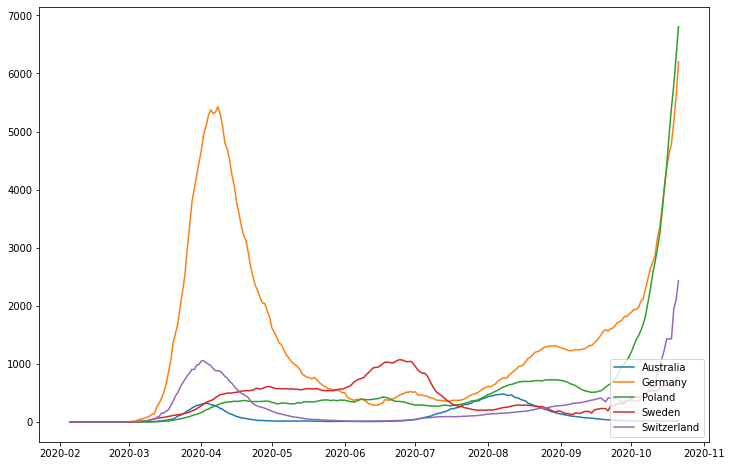

In [35]:
plt.figure(figsize=(12,8))

rolling14 = new_cases.rolling(window=14).mean()
for column in rolling14.columns:
    plt.plot(rolling14.index, rolling14[column], label=column)

plt.legend(loc=4)
#plt.yscale("log")

plt.show()

Figure shows covid new cases in time on logarythmic scale.

In [28]:
from datetime import timedelta

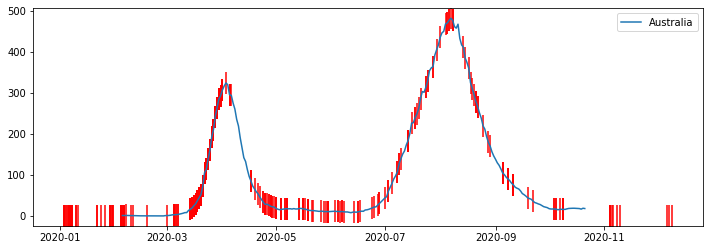

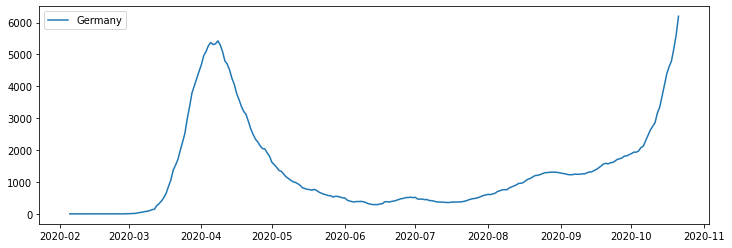

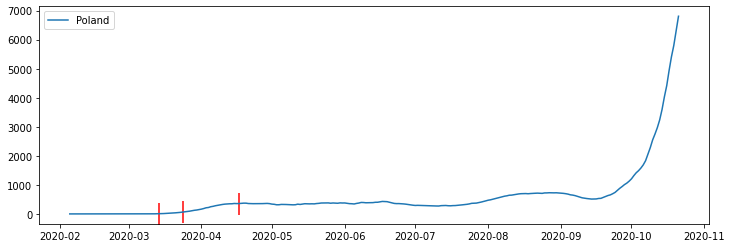

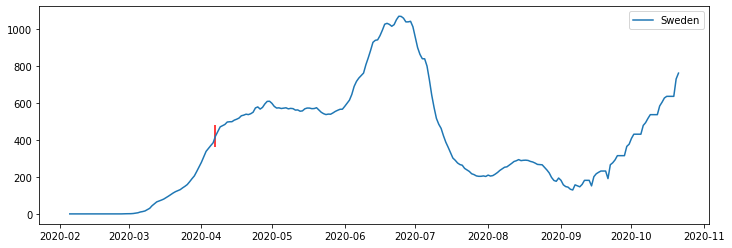

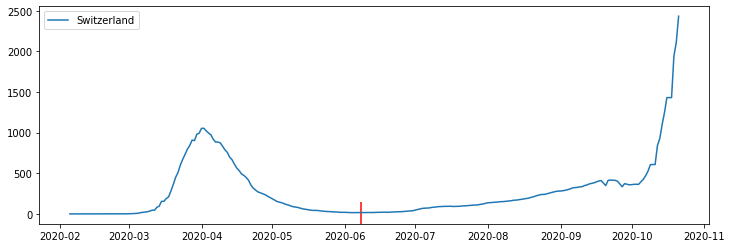

In [29]:
for i, column in enumerate(rolling14.columns):
    plt.figure(figsize=(12,4))
    plt.plot(rolling14.index, rolling14[column], label=column)
    plt.legend()
    for datex,row in df[df["region"]==column].iterrows():
        datex=datex+timedelta(1)
        val = 0.0
        if datex in rolling14[column].index:
            val =rolling14[column].loc[datex]
        val = 0.0 if val!=val else val
        plt.scatter(datex, val , marker="|", s=500, c="red")
#        plt.annotate(row.restriction, (datex, val), xytext=(-20,20), 
#            textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->',
#            connectionstyle='arc3,rad=0.5', color='red'))
    plt.show()

Plots contains marks on them which show when given restrcion was introduced.